In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score

## 1a.
#### Cleaning and Formatting portfolio data

In [2]:
portfolio = pd.read_csv('HW6Portfolio25.csv')

In [3]:
X = portfolio.drop(columns=['Date'])
scaler = StandardScaler()
stdX = scaler.fit_transform(X)

In [4]:
# Fitting KMeans clustering algo with params
clf = KMeans()

param = {
    'n_clusters':[2],
    'init': ['random', 'k-means++'],
    'n_init': [10, 15, 20],
    'random_state':[42],
    'max_iter': [30, 60, 90, 120]
}

grid =  GridSearchCV(clf, param, cv = 4)
kmeans = grid.fit(stdX)

In [5]:
y_pred = kmeans.predict(stdX)
outputMatrix = pd.DataFrame()
outputMatrix['Date'] = portfolio['Date']
outputMatrix['predict'] = y_pred
outputMatrix['Date'] = outputMatrix['Date']

In [6]:
outputMatrix

,Date,predict
0,19260701,0
1,19260702,0
2,19260706,0
3,19260707,0
4,19260708,0
...,...,...
25433,20230222,0
25434,20230223,0
25435,20230224,1
25436,20230227,0


## b.

In [7]:
portfolio = pd.read_csv('HW6Portfolio25.csv')
USREC = pd.read_csv("USREC.csv")
USREC = USREC.rename(columns={'observation_date':'Date'})

In [8]:
# Formats Date column to datetime
portfolio['Date'] = portfolio['Date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').date())
portfolio['Date'] = pd.to_datetime(portfolio['Date'])
# Compresses Date
portfolio = portfolio.groupby(pd.Grouper(key='Date', freq='M')).sum()
portfolio.reset_index(inplace=True)
portfolio['Date'] = portfolio['Date'].dt.to_period('M')

In [9]:
X = portfolio.drop(columns=['Date'])
scaler = StandardScaler()
stdX = scaler.fit_transform(X)

In [10]:
# Fitting KMeans clustering algo with params
clf = KMeans()

param = {
    'n_clusters':[2],
    'init': ['random', 'k-means++'],
    'n_init': [10, 15, 20],
    'random_state':[42],
    'max_iter': [30, 60, 90, 120]
}

grid =  GridSearchCV(clf, param, cv = 4)
kmeans = grid.fit(stdX)

In [11]:
grid.best_params_

{'init': 'random',
 'max_iter': 30,
 'n_clusters': 2,
 'n_init': 20,
 'random_state': 42}

In [12]:
y_pred = kmeans.predict(stdX)
outputMatrix = pd.DataFrame()
outputMatrix['Date'] = portfolio['Date']
outputMatrix['predict'] = y_pred
outputMatrix['Date'] = outputMatrix['Date']

#### Cleaning and Formatting USREC data

In [13]:
USREC['Date'] = pd.to_datetime(USREC['Date'],infer_datetime_format=True)
# index for wrong dates
print(USREC['Date'][541]) #541 
print(USREC['Date'][1416]) #1416
# Offset incorrect dates by 100years
USREC['Date'][541:1416] = USREC['Date'][541:1416] - pd.DateOffset(years=100)

# Formats USREC Date to datetime
USREC['Date'] = pd.to_datetime(USREC['Date'],infer_datetime_format=True)
USREC['Date'] = USREC['Date'].dt.to_period('M')

2000-01-01 00:00:00
2072-12-01 00:00:00


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_3311/1234024463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USREC['Date'][541:1416] = USREC['Date'][541:1416] - pd.DateOffset(years=100)


In [14]:
# merge USREC with portfolio by month
merged = pd.merge(USREC, outputMatrix[['predict', 'Date']], on='Date')
merged

,Date,USREC,predict
0,1926-07,0,0
1,1926-08,0,0
2,1926-09,0,1
3,1926-10,0,1
4,1926-11,1,0
...,...,...,...
1154,2022-10,0,0
1155,2022-11,0,0
1156,2022-12,0,1
1157,2023-01,0,0


In [15]:
score = accuracy_score(merged['USREC'], merged['predict'])
print('Accuracy:{0:f}'.format(score))

Accuracy:0.619500


In [16]:
f1_score(merged['USREC'],merged['predict'])

0.30551181102362207

The best accuracy rate I was able to achieve using K means is 61.9% and f1 score of 30.6% <br>
K means is not good at predicting recession times using the 25 portfolios, but it's not terrible

## c.
#### PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
# PCA 
pca = PCA(n_components=2)
x_9d = pca.fit_transform(stdX)
x_9d = pd.DataFrame(x_9d
             , columns = ['principal component 1', 'principal component 2'])
x_9d

,principal component 1,principal component 2
0,0.267540,-0.710399
1,1.136761,-0.974450
2,-1.223278,-0.524774
3,-3.042821,0.357797
4,1.134853,-0.522027
...,...,...
1155,6.180738,-1.281711
1156,1.959084,-1.782516
1157,-4.736206,0.564207
1158,5.641180,0.848972


In [19]:
kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(x_9d)

In [20]:
outputMatrix = pd.DataFrame()
outputMatrix['Date'] = portfolio['Date']
outputMatrix['label'] = y_pred
outputMatrix

,Date,label
0,1926-07,1
1,1926-08,1
2,1926-09,0
3,1926-10,0
4,1926-11,1
...,...,...
1155,2022-10,1
1156,2022-11,1
1157,2022-12,0
1158,2023-01,1


In [21]:
pcaMerge = pd.merge(USREC[['Date', 'USREC']], outputMatrix[['label', 'Date']], on='Date')

In [22]:
score = accuracy_score(pcaMerge['USREC'], pcaMerge['label'])
print('Accuracy:{0:f}'.format(1-score))

Accuracy:0.619500


In [23]:
f1_score(pcaMerge['USREC'], pcaMerge['label'])

0.22462203023758096

using PCA drops performance slightly

## 2a.
#### Hierarchical Clustering

In [24]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [25]:
portfolio = pd.read_csv('HW6Portfolio25.csv')
portfolio['Date'] = portfolio['Date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').date())
portfolio['Date'] = pd.to_datetime(portfolio['Date'])

In [26]:
X = portfolio.drop(columns=['Date'])
stdX = scaler.fit_transform(X.T)

In [27]:
complete_clustering = linkage(stdX, method="complete", metric="euclidean")

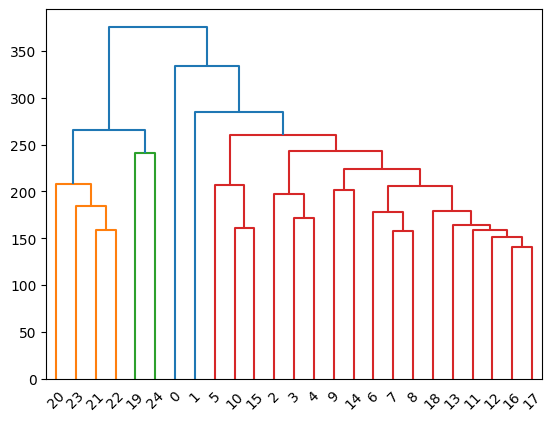

In [28]:
dendrogram(complete_clustering)
plt.show()

In [29]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
y_pred = cluster.fit_predict(stdX)
y_pred = np.array(y_pred)
y_pred

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0])

3 clusters does not seem like the right number of clusters. The dendrogram shows that the first two portfolios are not clustered with any of the other portfolios.

## b.

In [30]:
unique, counts = np.unique(y_pred, return_counts=True)
stats = dict(zip(unique, counts))
stats

{0: 8, 1: 1, 2: 16}

In [31]:
# Finds portfolios' index
c1Loc = np.where(y_pred==0)
c2Loc = np.where(y_pred==1)
c3Loc = np.where(y_pred==2)
c1Loc = np.array(c1Loc)
c1Loc = c1Loc.tolist()[0]
c2Loc = np.array(c2Loc)
c2Loc = c2Loc.tolist()[0]
c3Loc = np.array(c3Loc)
c3Loc = c3Loc.tolist()[0]

In [32]:
# for each cluster Df c1, c2, c3
c1 = pd.DataFrame()
for i in range(0, len(c1Loc)):
    # add the portfolios in respective cluster into Df
    c1[f'Cluster {i+1}'] = X.iloc[:,c1Loc[i]]
c2 = pd.DataFrame()
for i in range(0, len(c2Loc)):
    c2[f'Cluster {i+1}'] = X.iloc[:,c2Loc[i]]
c3 = pd.DataFrame()
for i in range(0, len(c3Loc)):
    c3[f'Cluster {i+1}'] = X.iloc[:,c3Loc[i]]

In [33]:
# calc avg between all portfolios at each observation
c1['Avg'] = c1.mean(axis=1)
c2['Avg'] = c2.mean(axis=1)
c3['Avg'] = c3.mean(axis=1)

In [34]:
c1['Date'] = portfolio['Date']
c2['Date'] = portfolio['Date']
c3['Date'] = portfolio['Date']

<AxesSubplot: xlabel='Date', ylabel='Avg'>

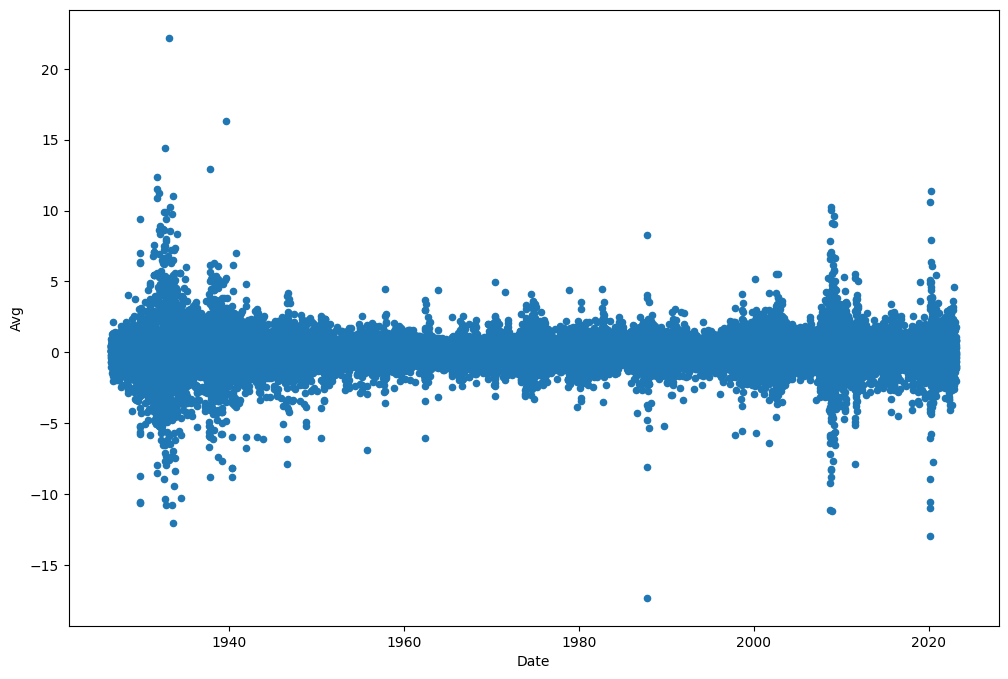

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
c1.plot.scatter(x='Date', y = 'Avg', ax = ax)

<AxesSubplot: xlabel='Date', ylabel='Avg'>

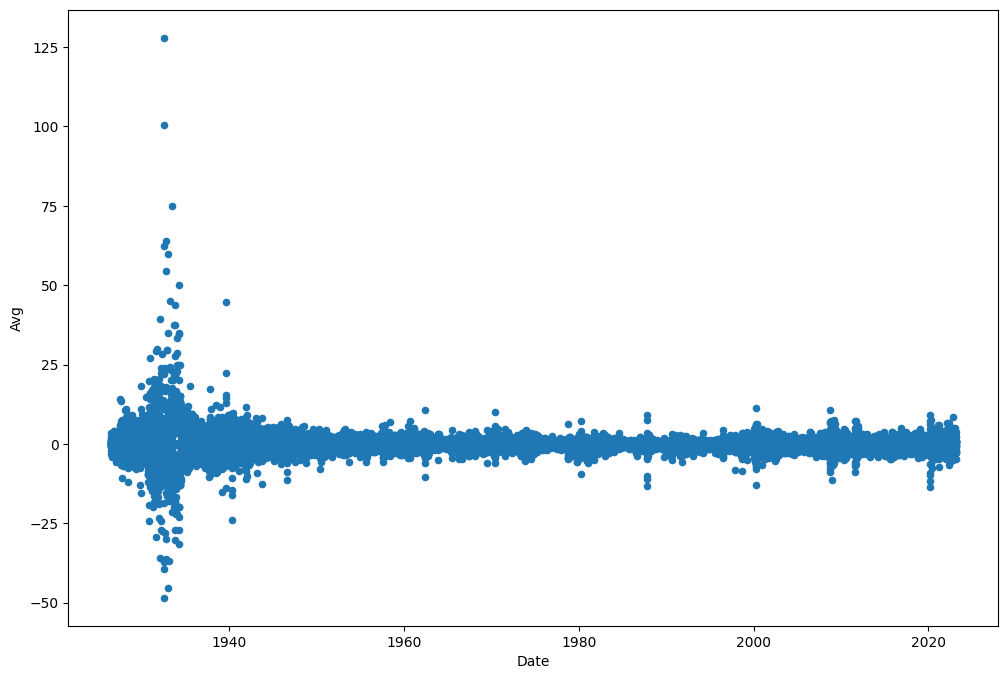

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
c2.plot.scatter(x='Date', y = 'Avg', ax = ax)

<AxesSubplot: xlabel='Date', ylabel='Avg'>

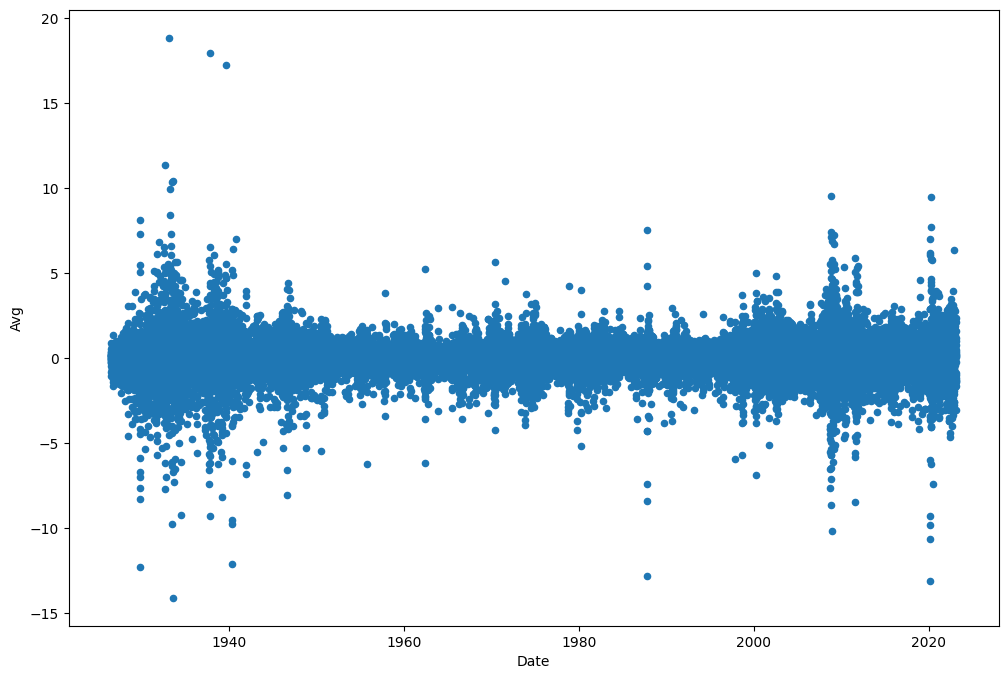

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
c3.plot.scatter(x='Date', y = 'Avg', ax = ax)

## c.

In [38]:
# Load the daily returns data into a DataFrame
df = pd.read_csv('HW6Portfolio25.csv', index_col=0)

# Perform PCA on the daily returns
pca = PCA(n_components=2)
stdX = scaler.fit_transform(X.T)
pca.fit(stdX)

# Transform the daily returns to their first two principal components
transformed = pca.transform(stdX)

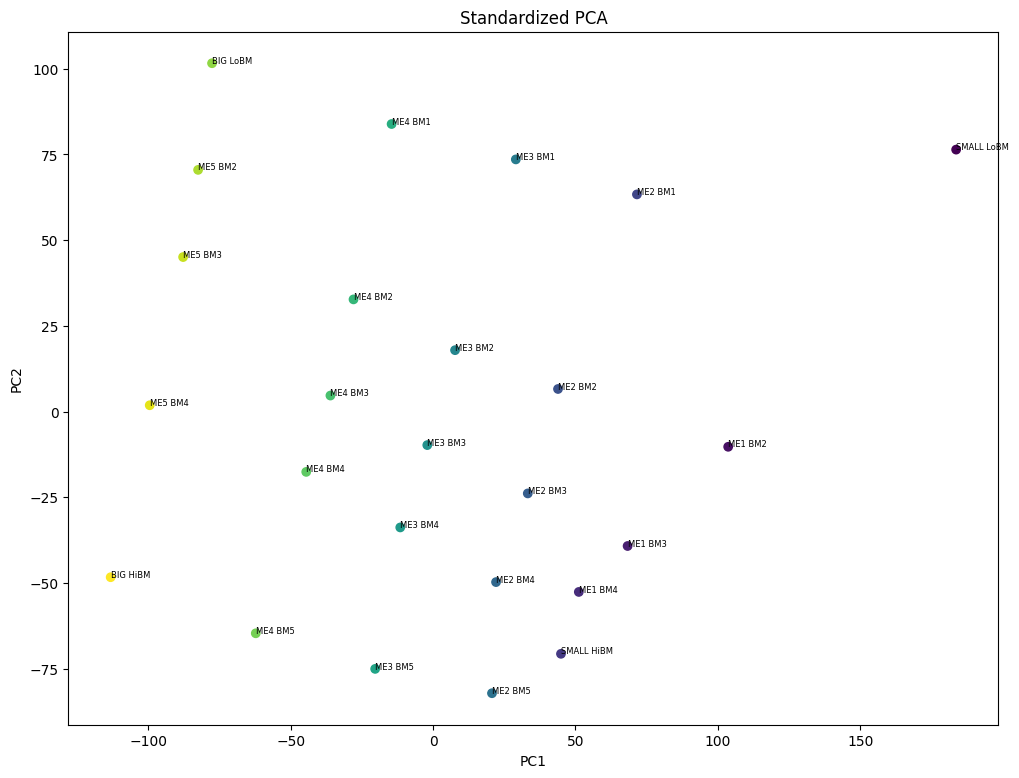

In [39]:
color_vals = np.arange(len(df.columns))
plt.figure(figsize=(12, 9))

# Plot the portfolios using their first two principal components
plt.scatter(transformed[:, 0], transformed[:, 1], c=color_vals)
for i, name in enumerate(df.columns):
    plt.annotate(name, (transformed[i, 0], transformed[i, 1]), fontsize=6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Standardized PCA')
plt.show()

In [40]:
# Load the daily returns data into a DataFrame
df = pd.read_csv('HW6Portfolio25.csv', index_col=0)

# Perform PCA on the daily returns
pca = PCA(n_components=2)
pca.fit(X.T)

# Transform the daily returns to their first two principal components
transformed = pca.transform(X.T)

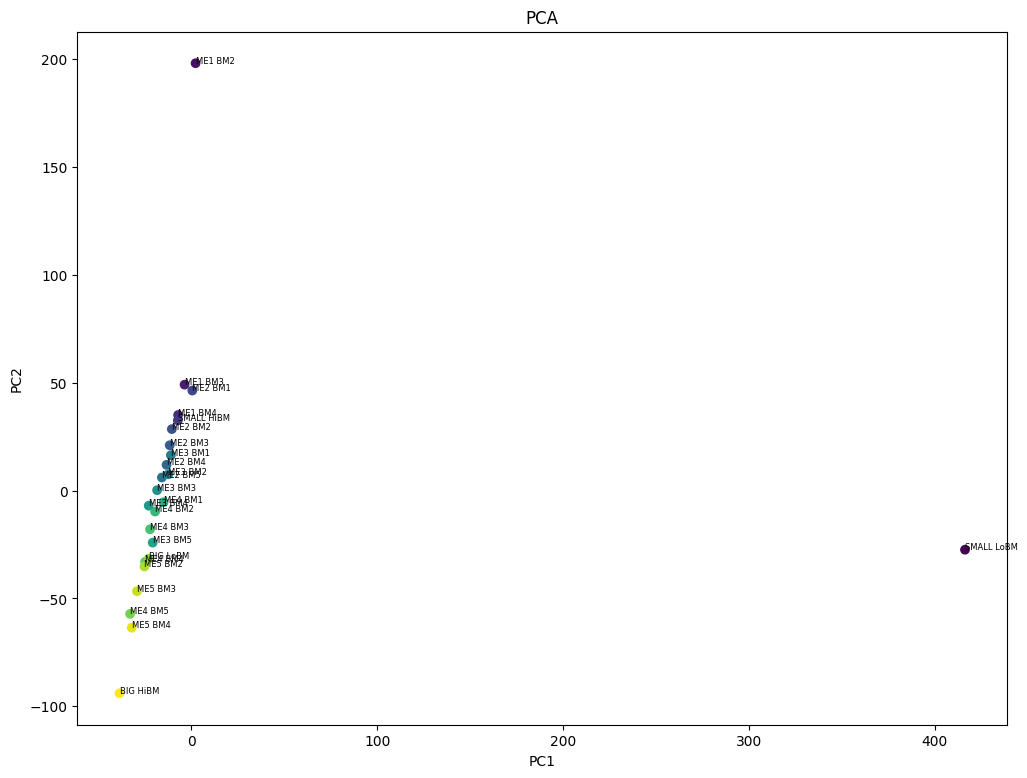

In [41]:
color_vals = np.arange(len(df.columns))
plt.figure(figsize=(12, 9))

# Plot the portfolios using their first two principal components
plt.scatter(transformed[:, 0], transformed[:, 1], c=color_vals)
for i, name in enumerate(df.columns):
    plt.annotate(name, (transformed[i, 0], transformed[i, 1]), fontsize=6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()